# Building and Optimizing an Emulator

Let's build an emulator for a quantum scattering problem with an optical potential! We will choose neutron scattering on the $^{40}$ Ca nucleus as our test problem. In particular, we want to build an emulator that can predict the differential elastic scattering cross section for this reaction, at a given energy as quickly and accurately as possible. 

We have the following Hamiltonian as the radial part of the scattering equation:

\begin{equation}
    F_\alpha(\phi)=\left(-\frac{d^2}{dr^2}+\frac{\ell(\ell+1)}{r^2}+U(r,\alpha)-p^2\right)\phi(r)=0,
\end{equation}

where a system with reduced mass $\mu$ interacts through a potential $V(r,\alpha)=U(r,\alpha)/2\mu$ with parameters $\alpha$, $\ell$ is the angular momentum quantum number, and $p$ is the asymptotic linear momentum. In the code implementation we re-scale the equation to work in dimensionless units $s=rp$. Our reduced basis expansion of $n$ basis can be written as:

\begin{equation}
   \phi(r) \approx \phi_0(r) + \sum_k^n a_k\phi_k(r)
\end{equation}


The goal of this tutorial is to demonstrate how to build such an emulator with ROSE, and then choose the optimal emulator configuration to accomplish this. For a video and other notebook resources on ROSE [check this link](https://indico.cern.ch/event/1223721/contributions/5394829/). The full derivation of the involved equations, both for the high fidelity and the reduced basis counter part, will be presented in an upcoming publication and linked here.


Let's get to it then. First, we'll import all the modules we need and set up the scattering system.

In [1]:
# pip install nuclear-rose (if you don't have it already)
# pip install nuclear-rose==0.9.4a0 
# import ROSE to construct the emulator
import rose

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import random
import datetime

plt.rcParams.update({'font.size': 12})

In [2]:
Starting_time=time.time()

## Setting up the Scattering System

We start by making some preliminary definitions for constants.

In [3]:
A = 40  # mass of the target

AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = (
    MASS_40CA * MASS_N / (MASS_40CA + MASS_N)
)  # reduced mass - we will do calculations in COM frame

# asymptotic energy and wavenumber in center-of-mass (COM) frame
energy = 14.  #  14.1  # MeV
k = np.sqrt(2 * MU * energy) / rose.constants.HBARC

# how many partial waves should we calculate?
l_max = 1
l_list = list(range(l_max + 1))

# domain of the differential cross section; the observable we want to emulate
angles = np.linspace(1, 179, 179)
# ROSE also has a convenient grid over radial space we can steal
# rho = rose.constants.DEFAULT_RHO_MESH.copy()
rho=np.linspace(1e-6, 8*np.pi,2000)
# rho=np.linspace(1e-4, 8*np.pi,2000)
s_0=6 * np.pi

In [4]:
#A subset of the angles in which we will deal with data

anglesX=np.array(list(range(19,165,5)))

## Define the Interaction: an Optical Potential

Let's define the functional forms for the interaction potentials we will use. We will use standard forms of the optical potential, with default parameters for $^{40}$Ca, as defined by [Koning and Delaroche](https://www.sciencedirect.com/science/article/pii/S0375947402013210?casa_token=qS1v6U4xDQEAAAAA:NIi9D5LpP3f05AMwRnvbQ6or8hSvXoEIgKBV56KA4l9aObCOVDAndmuCeIH77iuzoXMOOlAMyw). 

The potential we use includes the following terms, each with a set of parameters:

1. complex volume term with a Woods-Saxon shape; $V_v$, $W_v$, $R_v$, $a_v$
2. imaginary surface-peaked term with a Woods-Saxon derivative shape; $W_d$, $R_d$, $a_d$
3. Real spin-orbit (SO) coupling term with a Woods-Saxon derivative shape; $V_{so}$, $R_{so}$, $a_{so}$.


\begin{equation}
    \begin{aligned}
      &V(r;\alpha,\ell,j) =-V_v f_\text{WS}(r,R_v,a_v) - iW_v f_\text{WS}(r,R_v,a_v) \\
      &-i4a_dW_d \frac{d}{dr}f_\text{WS}(r,R_d,a_d) \\
      &+2\ell\cdot s V_{so}  \Big(\frac{\hbar}{m_\pi c}\Big)^2 \frac{1}{r} \frac{d}{dr}f_\text{WS}(R_{so},a_{so}),
    \end{aligned}
\end{equation}


The Woods-Saxon functional form (and it's derivative) is our model for the geometric shape of the effective potential the neutron feels as a function of it's distance from the $^{40}$ Ca nucleus. It looks like this:

\begin{equation}
f(r;R,a) = \frac{1}{1 - \exp{\frac{r-R}{a}}}.
\end{equation}


All depth parameters ($V_i$, $W_i$) are given in MeV, and geometric parameters $r_i$ and $a_i$ are given in fm. We define our vector of parameters as 

\begin{equation}
\boldsymbol{\alpha} = \begin{bmatrix}
V_v &  W_v & R_v & a_v & W_d & R_d & a_d & V_{so} & R_{so} & a_{so}
\end{bmatrix}
\end{equation}

Let's set this up:


In [5]:
# shape of interaction for volume term
def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


# shape of interaction for surface-peaked and spin-orbit coupling terms
def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (-1j * Wv - Vv) * wood_saxon(r, Rv, av) - (4j * ad * Wd) * wood_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = rose.constants.HBARC / MASS_CHARGED_PION


# spin-orbit (SO) coupling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso) * mso**2 * ldots * wood_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 10

In [6]:
#Parameters region and sampling for training. These are chosen close to our prior knowledge of where
#we expect the final parameters to be.

Vv0 = 45
Wv0 = 2
Wd0 = -7
Vso = 5



Rv0 = 4

Rd0 = 4
Rso = 4

av0 = 0.6

ad0 = 0.6
aso = 0.6


#This is the center of our prior and around where we will train our RBM emulator
alphaCentral = np.array([Vv0, Wv0, Wd0, Vso, Rv0, Rd0, Rso, av0 , ad0, aso])

## Set up the Training and Testing Regions for the Emulator

It is now our goal to define an emulator that, given an arbitrary point in a closed subset of this 11D space, reproduces the scattering solutions of the Schrödinger equation for the center-of-mass frame of a 14.1 MeV neutron and a $^{40}$ Ca nucleus. To do this, we will use a high-fidelity (HF) solver to construct a basis of solutions as we perturb $\boldsymbol{\alpha}$ around our region of interest, and then construct a suitable reduced basis emulator from it. 

Notice that the functional form of the Woods-Saxon (and its derivative) is not a simple linear function of the parameters $R$ and $a$. To be more precise, we can't factorize this function into the product of functions of just the parameters $R$ and $a$, and another function of just the domain of the problem $r$. A mathematician would say that this operator is not "affine" in the geometric parameters. To handle emulating the potential operator, we will need to construct an approximation that is factorizable using something called the Empirical Interplation Method (EIM). Chapters 2 and 3 of [this book](https://dr.ascsn.net/) contain a more detail view (within a nuclear physics context) of the reduced basis method and the empirical interpolation method we use in ROSE. 

In summary, the EIM consists of approximating the potential with $m$ reduced basis in the same way as we did for our solutions:

\begin{equation}
V(r; \alpha)  \approx V_\text{EIM} (r; \alpha)  = \sum_k^m \beta_k(\alpha) V_k(r).
\end{equation}

Fortunately, ROSE will handle all of these details for us, so we don't have to get our hands too dirty! Let's take a look at how to use ROSE to make ourselves a nice emulator.

We will create training boundaries 20% above and below our mean values for the parameters, and therefore define the bounds of a hyper-box in our 11D parameter space that contains this region of interst. We will train our emulator with random samples of $\alpha$ from this box, and we would like to be accurate throughout the entire box.

In [7]:
scaleTraining = 0.2

bounds = np.array(
    [
        alphaCentral - np.fabs(alphaCentral * scaleTraining),
        alphaCentral + np.fabs(alphaCentral * scaleTraining),
    ]
).T

In [8]:
bounds

array([[36.  , 54.  ],
       [ 1.6 ,  2.4 ],
       [-8.4 , -5.6 ],
       [ 4.  ,  6.  ],
       [ 3.2 ,  4.8 ],
       [ 3.2 ,  4.8 ],
       [ 3.2 ,  4.8 ],
       [ 0.48,  0.72],
       [ 0.48,  0.72],
       [ 0.48,  0.72]])

In [9]:
def sample_points(npoints, bounds,initial_seed=None):
    sampler = qmc.LatinHypercube(d=len(bounds), seed=initial_seed)
    sample = sampler.random(npoints)
    scaled = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled


n_test = 100
n_train = 100

seed_train=142857
seed_test=142857*2

training_samples = sample_points(n_train, bounds,initial_seed=seed_train)
test_samples = sample_points(n_test, bounds,initial_seed=seed_test)


np.savetxt("train_params.txt",training_samples)
np.savetxt("test_params.txt",test_samples)

In [10]:
n_train_EIM=1000

seed_EIM=142857*3

train_EIM = sample_points(n_train_EIM, bounds, initial_seed=seed_EIM)
np.savetxt("train_params_EIM.txt",train_EIM)

## Construct the Interaction, the High-Fidelity Solver, and the Emulator

Great, we have all the points we need to sample. Now let's define an InteractionEIMSpace in ROSE, which encodes the original and Empirically-Interpolated potential we've defined for each partial wave. Then we will use this to construct our emulators and our High-Fidelity (HF) solver, and take a look at how snapshots of the HF solutions vary over our training space.  We will use the default EIM setup. ROSE will automatically use the exact potential for the HF solver, and the EIM decomposed potential for emulation.

By the way, we like to call HF solutions of our system "snapshots". In this case, we use snapshots to refer to the test observables (differential cross sections), but we will also use it to refer to the training wavefunctions we generate with the HF solver, which ROSE uses to construct the reduced basis.

We will start by using a reduced basis of 4 elements, and the same number of EIM terms as there are parameters in $\boldsymbol{\alpha}$; in this case, 11. We will pass in the bounds of our parameter space, and the `InteractionEIMSpace` object will automatically find 1000 (by default) well-distributed points in our parameter space to train the EIM factorization. Both these numbers can be easily changed.

In [11]:
# Finally, we can invoke ROSE. Let's build an InteractionEIMSpace, running over lmax partial waves,
# with the optical potential we defined above.
interactions = rose.InteractionEIMSpace(
    optical_potential,
    nparams,
    MU,
    energy,
    l_max,
    training_info=train_EIM,
    rho_mesh=rho,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential,
    explicit_training = True,
    n_basis=10
)

Now that we have our interaction, let's set up 1) a HF solver and 2) an emulator. In ROSE, these tasks are handled by the same object; `ScatteringAmplitudeEmulator`. We will set one up, and calculate snapshots of the cross sections at our test points.

In [12]:
# let's build our first reduced basis emulator
emulator = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    l_max,
    s_mesh=rho,
    s_0=s_0,
    n_basis=10,
    angles=angles / 180 * np.pi,
    hf_tols=[
        1e-9,
        1e-9,
    ],  # these are the relative and absolute tolerances for the HF Runge-Kutta solver
)

100%|█████████████████████████████████████████████| 2/2 [00:18<00:00,  9.20s/it]
/Users/furnstah/Dropbox/Anaconda/anaconda3/envs/ROSE-env/lib/python3.11/site-packages/rose/utility.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])


In [13]:
rbe_s = emulator.rbes[0][0]

## Figure 1

In [14]:
plt.rcParams.update({'font.size': 15})  # global fontsize adjustment (we'll tweak labels separately)

In [15]:
list_of_samples = np.array([11, 12, 2, 4, 24],dtype=int)
list_of_samples = np.array([12, 2, 4, 24],dtype=int)
print(list_of_samples)
# colors are: blue, orange, green, red, purple 

[12  2  4 24]


In [16]:
# phi_exact = np.array(
#     [rbe_s.basis.solver.phi(alpha, rho, 0) for alpha in test_samples[:10]]
# )
# phi_emu = np.array(
#     [rbe_s.emulate_wave_function(alpha) for alpha in test_samples[:10]]
# )

In [17]:
phi_exact = np.array(
    [rbe_s.basis.solver.phi(alpha, rho, 0) for alpha in test_samples[list_of_samples]]
)
phi_emu = np.array(
    [rbe_s.emulate_wave_function(alpha) for alpha in test_samples[list_of_samples]]
)

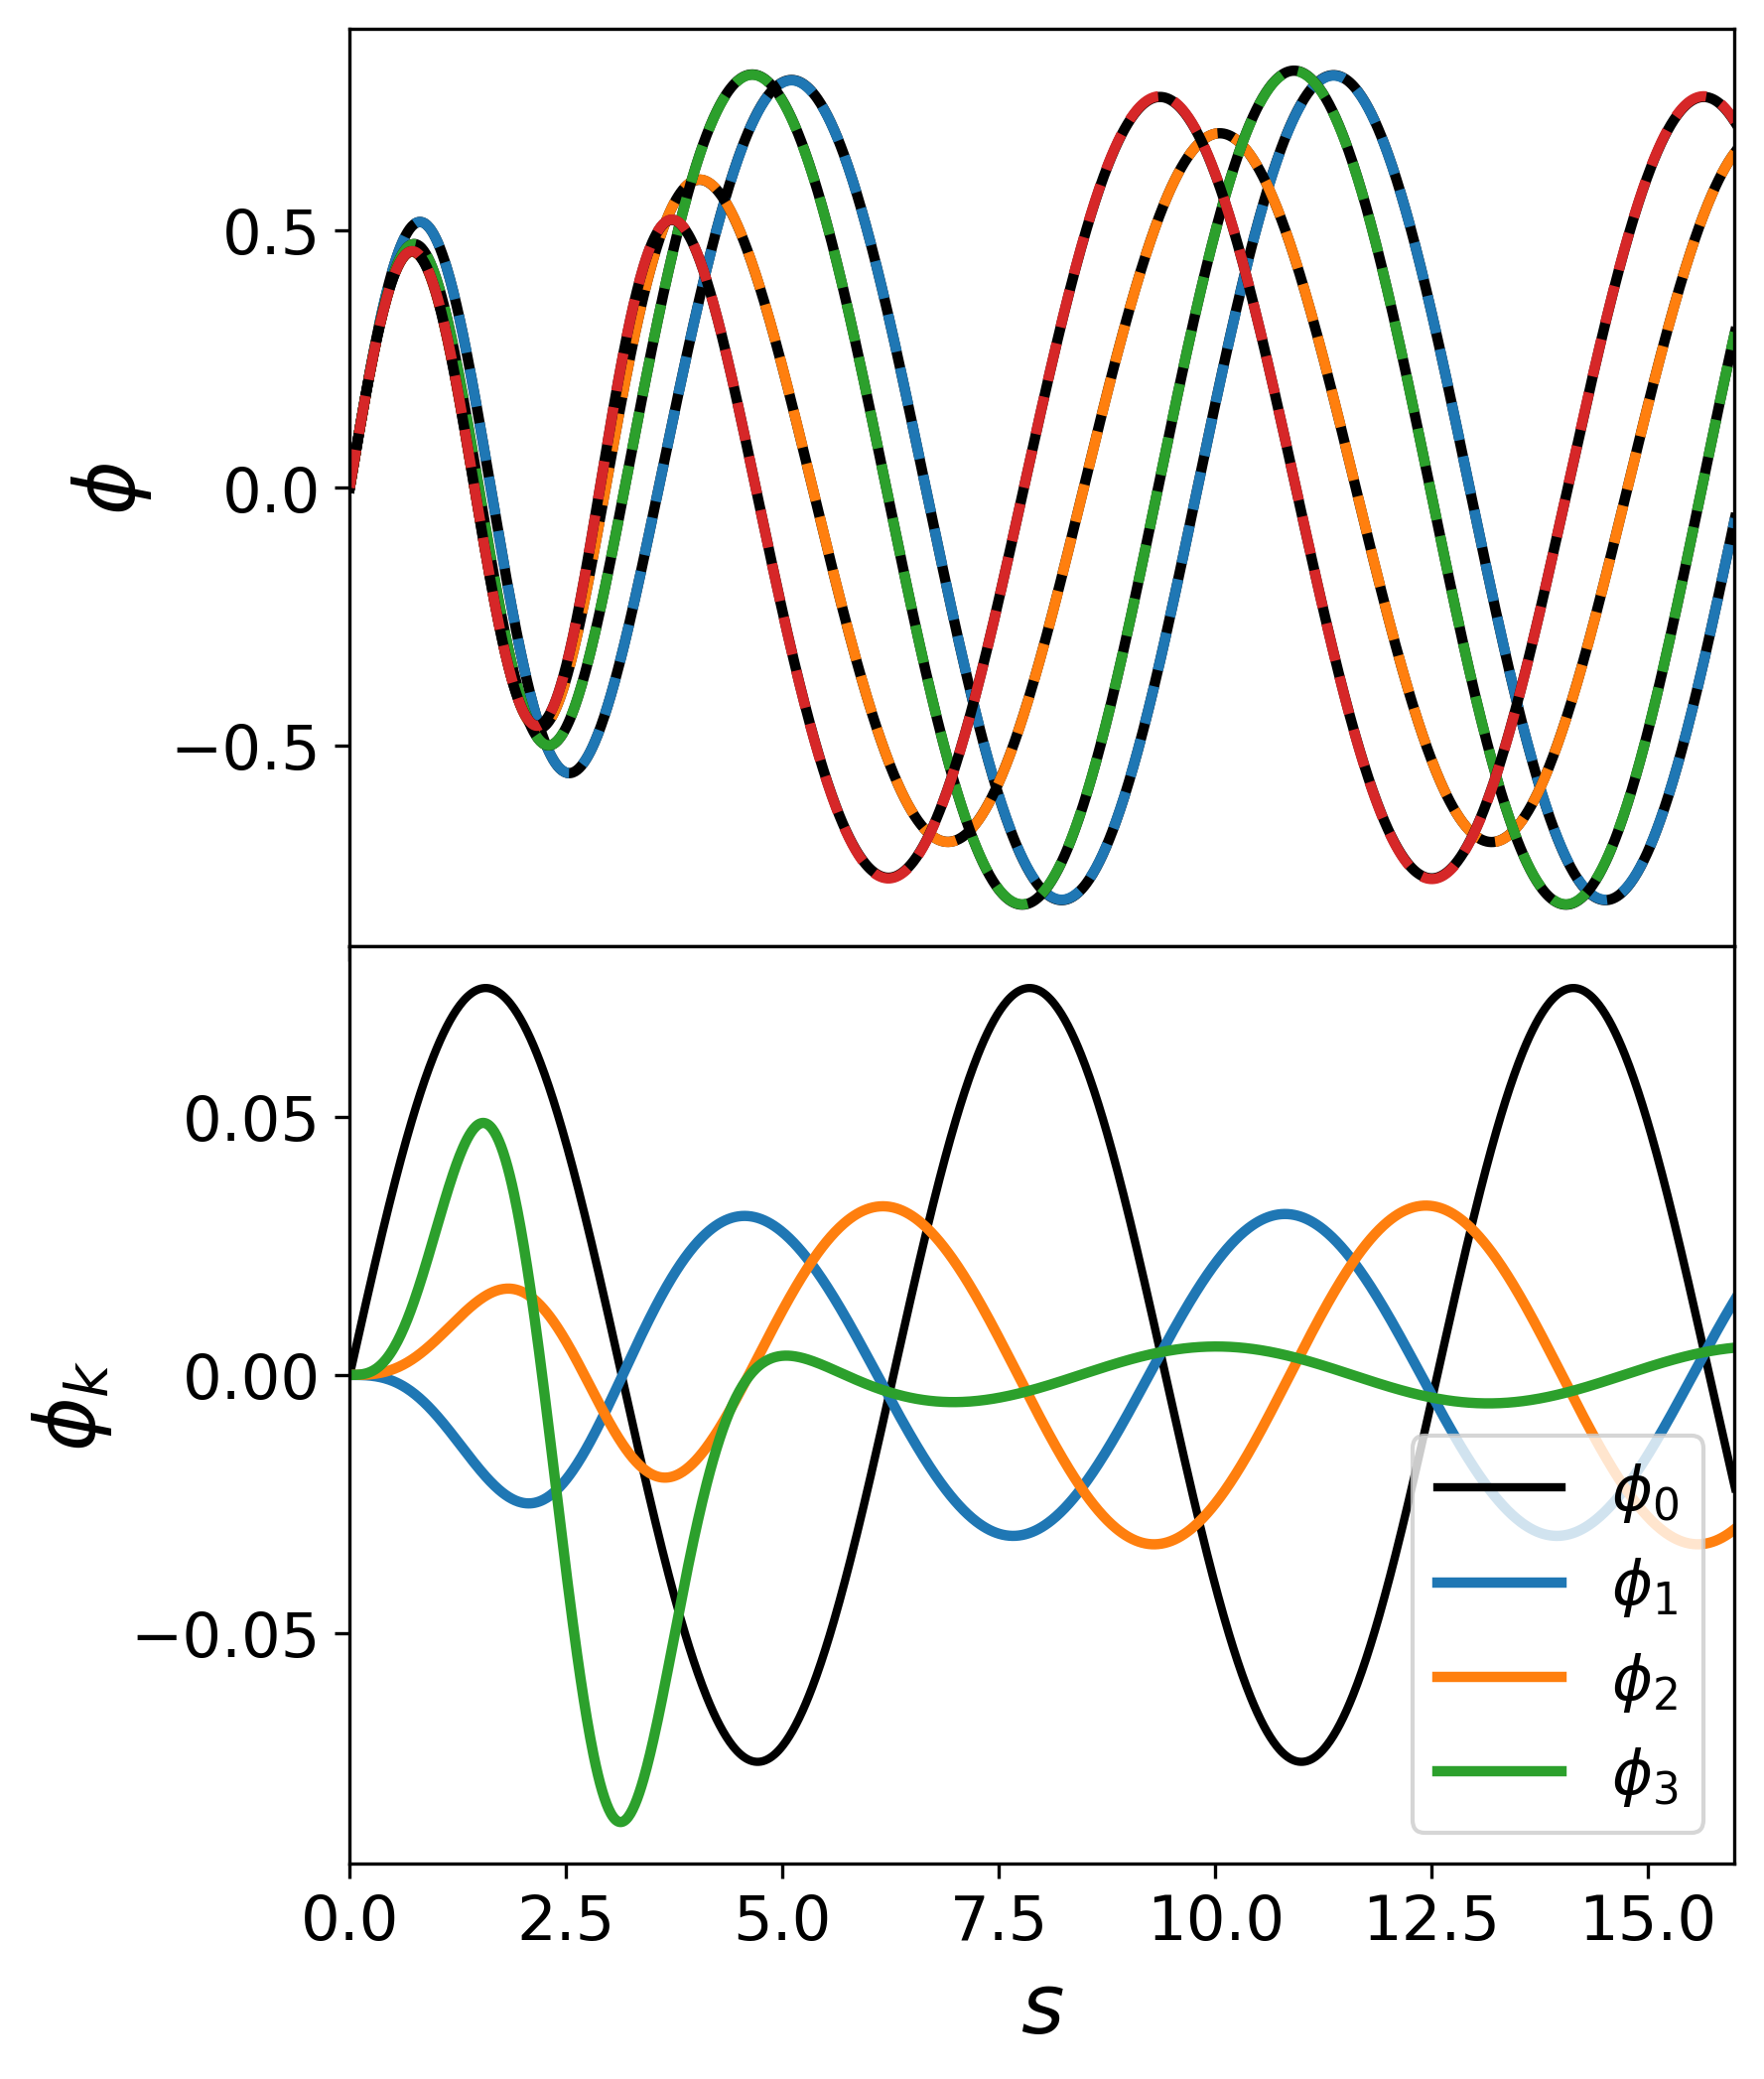

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(6, 2*4), dpi=300)
fig.patch.set_facecolor('white')

label_fontsize = 20

for i in range(4):
    ax[0].plot(rho, phi_exact[i].real, color='black', lw=2.5)
    ax[0].plot(rho, phi_emu[i].real, linestyle='--', lw=2.5)

ax[0].set_ylabel(r'$\phi$',fontsize=label_fontsize)

phi_0_scale = 0.075
#ax[1].plot(rho, phi_0_scale * rbe_s.basis.phi_0.real, color='black', lw=2)
ax[1].plot(rho, phi_0_scale * rbe_s.basis.phi_0.real, color='black', lw=2, label=rf'$\phi_0$')
for i in range(3):
    pc = rbe_s.basis.vectors[:, i]
    ax[1].plot(rho, pc.real, lw=2.5, label=rf'$\phi_{i+1}$')
    
ax[1].set_ylabel(r'$\phi_k$',fontsize=label_fontsize)

plt.subplots_adjust(hspace=0)
ax[0].set_xticklabels('')
ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_xlim((0,16))
ax[1].set_xlim((0,16))
ax[1].set_xlabel(r'$s$',fontsize=label_fontsize)
ax[1].legend()
plt.savefig('figures/TrainingWaveFunctions_phi0.pdf', dpi=300, bbox_inches ="tight")

## Figure 2

In [19]:
u_exact = np.array(
    [rbe_s.interaction.tilde(rho, alpha) for alpha in test_samples]
)

u_emu = np.array(
    [rbe_s.interaction.tilde_emu(alpha) for alpha in test_samples]
)

In [20]:
xs = np.array(
    [rbe_s.interaction.tilde(rbe_s.interaction.match_points, alpha) for alpha in test_samples]
)

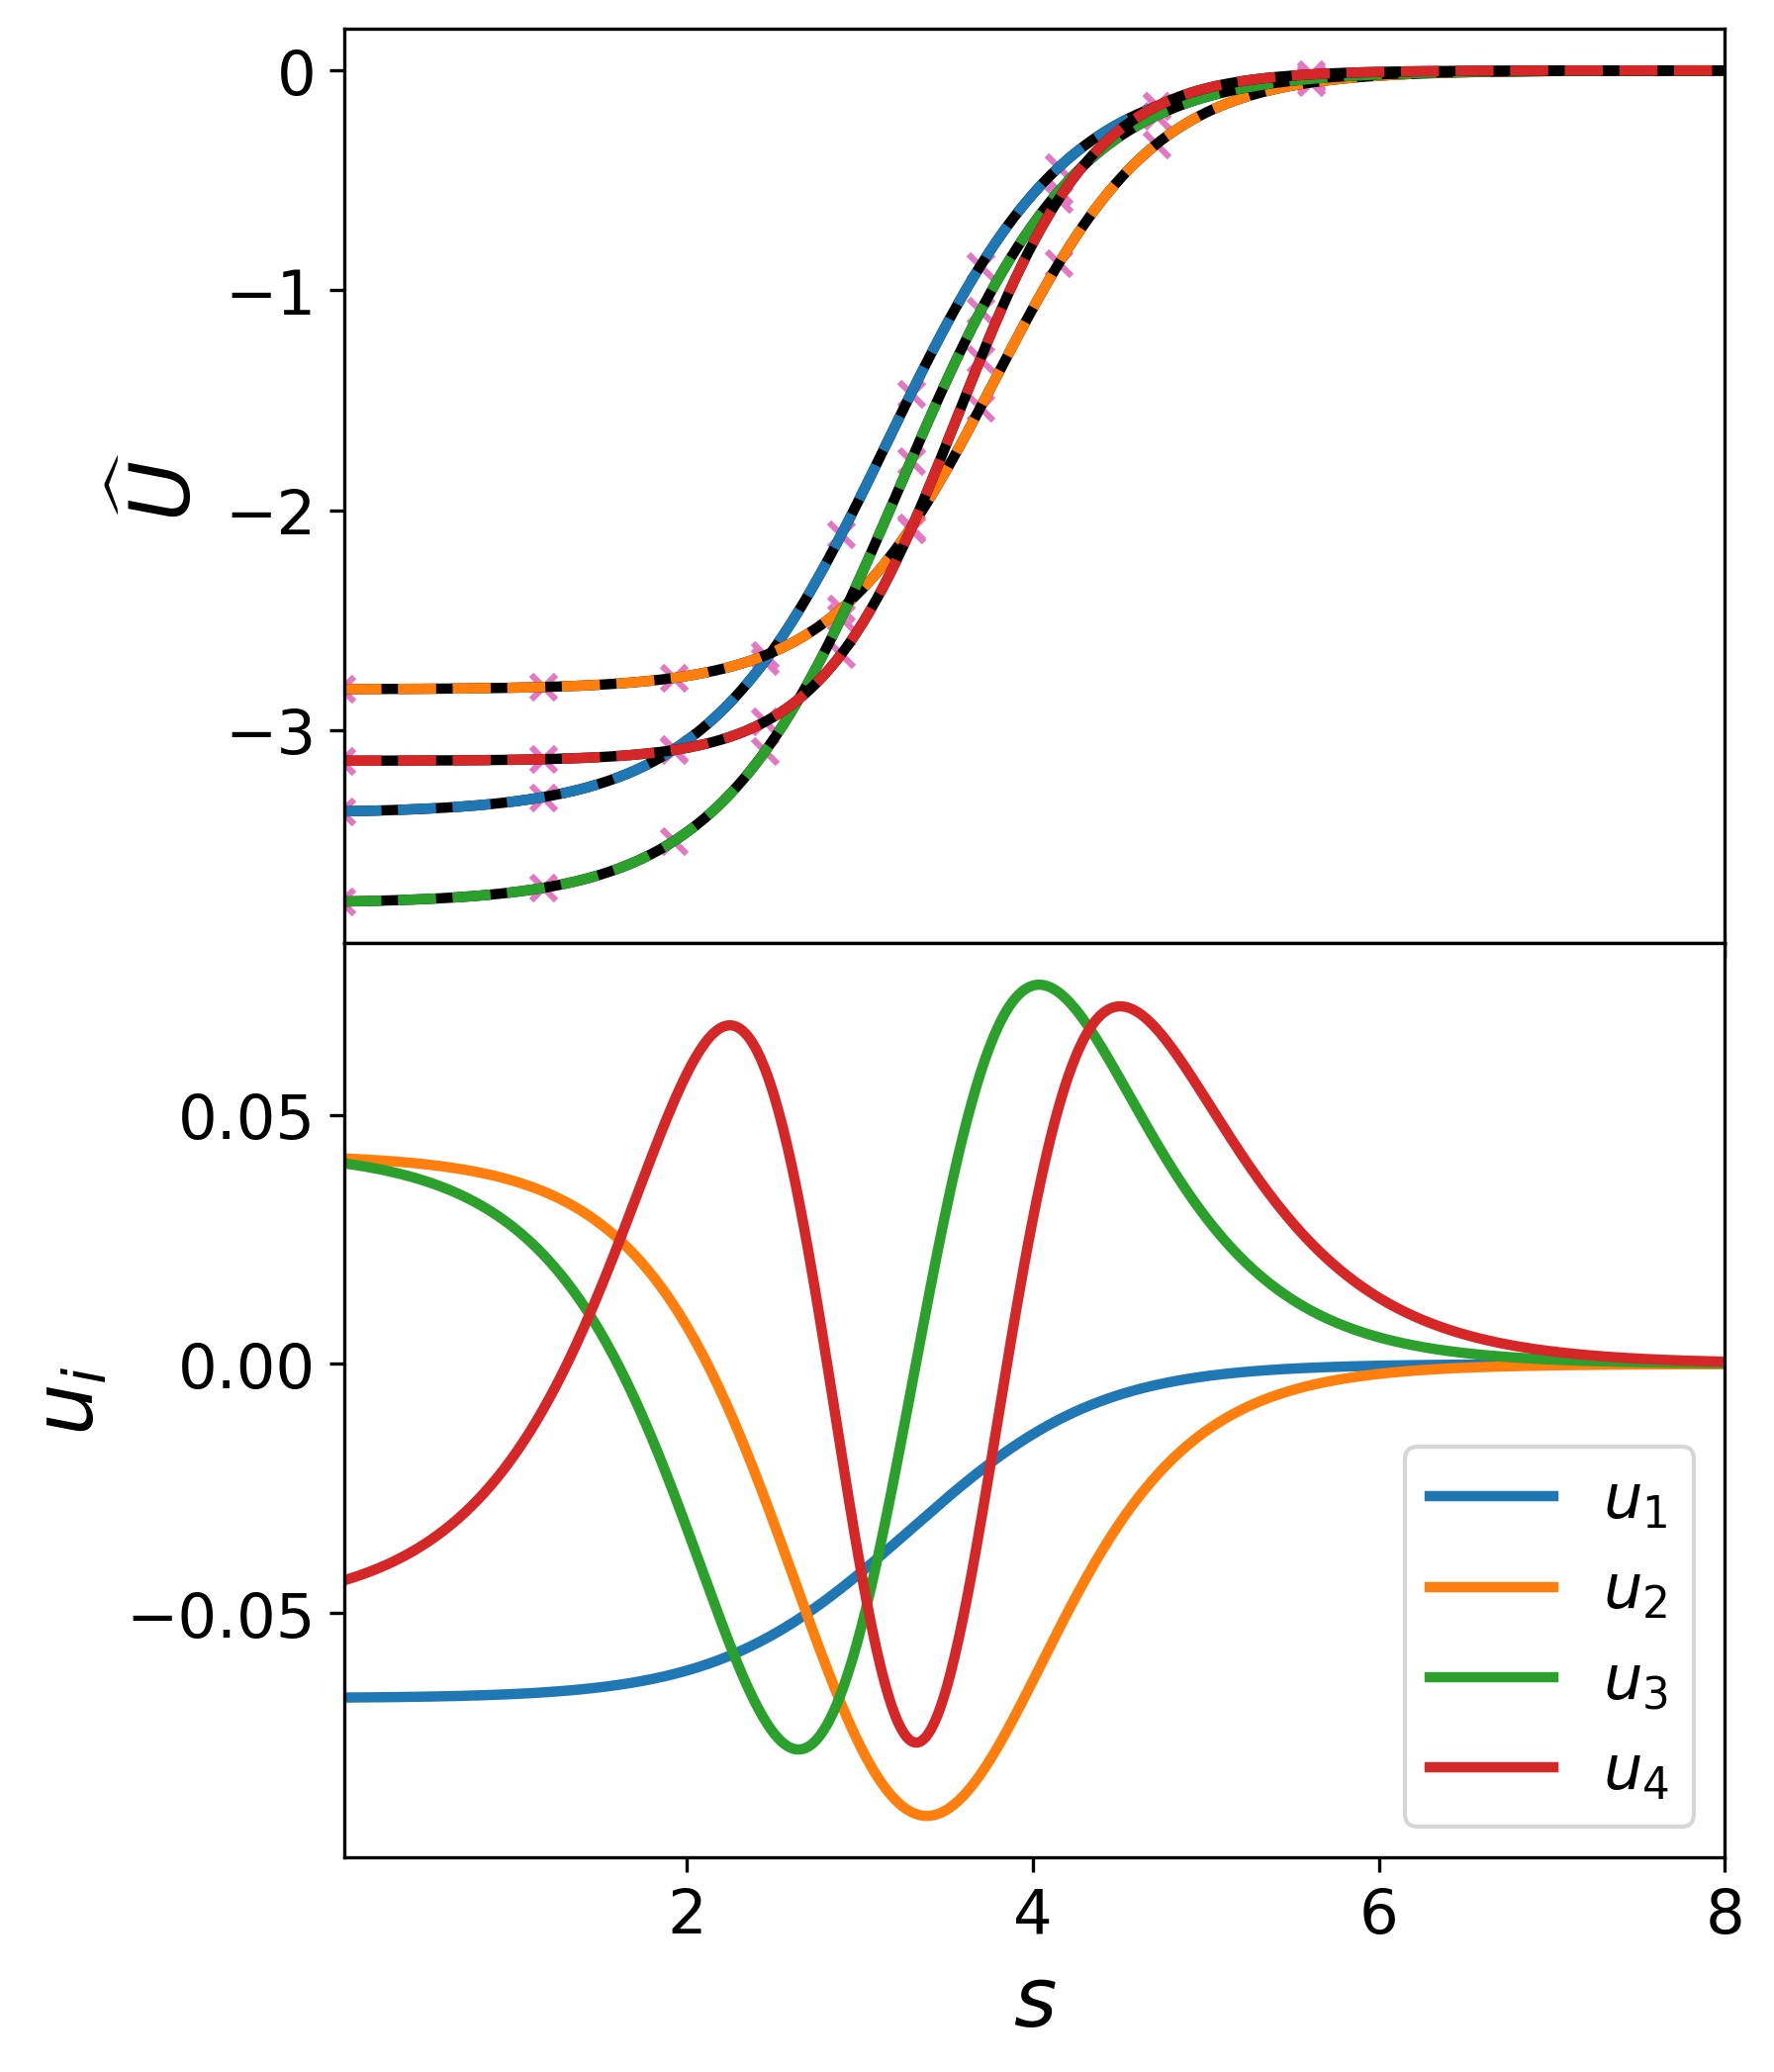

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(6, 2*4), dpi=300)
fig.patch.set_facecolor('white')

for i in range(4):
    exact = u_exact[i]
    emu = u_emu[i]
    # ax[0].plot(rho, exact.real)
    # ax[0].plot(rho, exact.real, color='black', linestyle='--')
    ax[0].plot(rho, exact.real, color='black', lw=2.5)
    ax[0].plot(rho, emu.real, linestyle='--', lw=2.5)
    ax[0].scatter(rbe_s.interaction.match_points, xs[i].real, marker='x', color='C6')

# ax[0].set_xlabel(r'$s$')
ax[0].set_ylabel(r'$\widehat{U}$',fontsize=label_fontsize)
# ax[0].

for i in range(4):
    basis_function = rbe_s.interaction.snapshots[:, i]
    ax[1].plot(rho, basis_function.real, color=f'C{i}', lw=2.5, label=rf'$u_{i+1}$')

ax[1].set_xlabel(r'$s$',fontsize=label_fontsize)
ax[1].set_ylabel(r'$u_i$',fontsize=label_fontsize)
# ax.set_xscale('log')
ax[1].set_xlim([2e-2, 8])
ax[0].set_xlim(ax[1].get_xlim())
ax[0].set_xticklabels('')
# ax[0].set_xticks(ax[1].get_xticks())
#ax[1].set_ylim([-0.1, 0.1]);
ax[1].legend()

plt.subplots_adjust(hspace=0)
plt.savefig('figures/TrainingPotential.pdf', dpi=300, bbox_inches ="tight")